# Softmax


In [1]:
import random
import numpy as np
from rd.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'rd/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Loss

In [3]:
def softmax_loss(W, X, y, reg):
    """
    Softmax loss function

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    num_train = X.shape[0]
    
    scores = X.dot(W)
    softmax_output = np.exp(scores) / np.sum(np.exp(scores), axis = 1).reshape(-1,1)
    loss = -np.sum(np.log(softmax_output[range(num_train), y]))
    loss /= num_train 
    loss += reg * np.sum(W * W)

    # compute the gradient
    # first compute dS: the gradient of the loss function with respect to the scores
    dS = softmax_output.copy()
    dS[range(num_train), y] += -1
    dW = (X.T).dot(dS)
    dW = dW / num_train

    return loss, dW

In [4]:
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss(W, X_dev, y_dev, 0.0)

print('loss: %f' % loss)

loss: 2.371933


## Training

In [5]:
from rd.classifiers import LinearClassifier

"""
def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
    ...
    
def predict(self, X):
    ...

def loss(self, X_batch, y_batch, reg):
    ...
"""

class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss(self.W, X_batch, y_batch, reg)

In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.3 on the validation set.
results = {}
best_val = -1
best_softmax = None

learning_rates = [10**(-f) for f in np.arange(4, 6, 0.5)]
regularization_strengths = [10**(f) for f in np.arange(0.5, 2, .5)]

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train,y_train, learning_rate = lr, reg =  rs,
                      num_iters = 100, batch_size = 200,verbose = False)
        acc_training = np.mean(softmax.predict(X_train) == y_train)
        acc_val = np.mean(softmax.predict(X_val) == y_val)
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, rs, acc_training, acc_val))
        results[(lr,rs)] = (acc_training,acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmax
            best_params = (lr,rs)

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best params: (%e, %e)' % best_params)

lr 1.000000e-04 reg 3.162278e+00 train accuracy: 0.278163 val accuracy: 0.284000
lr 1.000000e-04 reg 1.000000e+01 train accuracy: 0.286653 val accuracy: 0.255000
lr 1.000000e-04 reg 3.162278e+01 train accuracy: 0.243510 val accuracy: 0.242000
lr 3.162278e-05 reg 3.162278e+00 train accuracy: 0.286633 val accuracy: 0.271000
lr 3.162278e-05 reg 1.000000e+01 train accuracy: 0.214673 val accuracy: 0.221000
lr 3.162278e-05 reg 3.162278e+01 train accuracy: 0.255061 val accuracy: 0.283000
lr 1.000000e-05 reg 3.162278e+00 train accuracy: 0.273694 val accuracy: 0.276000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.294673 val accuracy: 0.266000
lr 1.000000e-05 reg 3.162278e+01 train accuracy: 0.260857 val accuracy: 0.257000
lr 3.162278e-06 reg 3.162278e+00 train accuracy: 0.277082 val accuracy: 0.279000
lr 3.162278e-06 reg 1.000000e+01 train accuracy: 0.274980 val accuracy: 0.272000
lr 3.162278e-06 reg 3.162278e+01 train accuracy: 0.272510 val accuracy: 0.290000
lr 3.162278e-06 reg 3.162278

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.268000


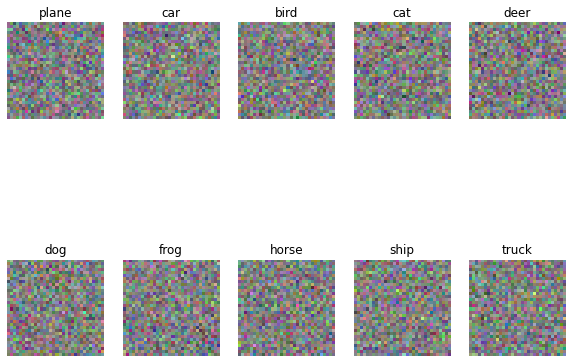

In [8]:
# Visualize the learned weights for each class
w = W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])